In [4]:
"""
SENTENCEPIECE v0.1

REFERENCE:
https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb
https://github.com/google/sentencepiece

EN-DE : Euparl, News, CCrawl, 
DE-EN : idem

EN-LT : Eupar

EN-MR : LoRes21
EN-GA : LoRes21

tokenized with sacremoses

Lenght mu = arithmetic mean of target seqs after encoding
Freq@95% = least freq in the 95% of vocab (log)

vocab_sizes = [500, 1000, 2000, 4000, 8000, 16000, 32000, 48000, 64000]

!!! BPE and SentPiece voc_size are not comparable, SentPiece gives error over max value that changes with data
    > limit at 8k
    > bacause of max number of unique forms in train data?
    > clarify vocab_size vs merge operations. does sentencepiece uses vocab or merge for bpe implementation?
    
!!! in original paper tokenized with Sacremoses but it has no option to change voc_size
    > sentencepiece has a bpe mode and char, test that and adapt functions and vocab_sizes to accomodate that
        > sentencepiece implementation is good enough
        
!!! get logs of training and tokenization speed and other output to df and save csv for final run
    > check the correctness of freq@95 and avg_len stats

!!! implement hft in class
    > kind of works, problems with ga pretokenized
    > finish implementation, convert outputs to dict for implementation
    
!!! better plots
    > find good variables to correlate
    > grid plots, change df to include dataset, model, value


build BleuTester with trained NMT
"""

from pathlib import Path
import os
import sentencepiece as spm
import json
import time
import shutil
import ast
import shutil
import pandas as pd
import seaborn as sns
import re


In [43]:
class TokBuilder:
    """
    builds tokenizers and freq dict for lang pair. can use unigram, bpe, char model_type
    """
    def __init__(self, pair, model_type):
        self.pair = pair
        self.langs = pair.split("_")
        self.src_lang = self.langs[0]
        self.tgt_lang = self.langs[1]
        self.model_type = model_type

    def count_chars(self, lang):
        """
        returns number of unique chars in file for char vocab_size
        """

        file_path = f'./data/{self.src_lang}_{self.tgt_lang}/train.{lang}'

        with open(file_path, 'r') as file:   
            unique = []

            for line in file.readlines():
                for char in line:
                    if char not in unique:
                        unique.append(char)

        return int(len(unique))

    
    def make_batches(self, lang):
        """
        Makes batches of 5_000 lines from bigger txt file for the selectet lang
        """
        
        file_path = f'./data/{self.src_lang}_{self.tgt_lang}/train.{lang}'
        file = open(file_path, 'r')
        data = file.readlines()
        file.close()

        text_data = []
        file_count = 0

        for sample in data:
            sample = sample.replace('\n', '')
            text_data.append(sample)
            
            save_path = f'./data/{self.src_lang}_{self.tgt_lang}/train/text/train_{file_count}.{lang}'
            
            if len(text_data) == 5_000:
                # once we hit the 5K mark, save to file
                with open(save_path, 'w+', encoding='utf-8') as fp:
                    fp.write('\n'.join(text_data))
                text_data = []
                file_count += 1

        with open(save_path, 'w+', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
    
    def gather_files(self, lang):
        """
        Returns the paths to the training batches for the selected lang
        """
        
        self.make_batches(lang)
        paths = [str(x) for x in Path(f'./data/{self.src_lang}_{self.tgt_lang}/train/text').glob(f'**/*.{lang}')]
        return paths

    def train_tokenizer(self, lang, vocab_size):
        """
        Trains a SentencePiece tokenizer for the selected lang and vocab_size
        """
        
        print(f'Training tokenizer for {lang} with vocab_size of {vocab_size}')
        
        tokenizer_name = f'{lang}_{self.model_type}_{vocab_size/1000}k'
        
        
              
        paths = self.gather_files(lang)
        
        #the revoming part gets the script stuck after a while. removing manually makes it work
        
        tokenizer_path = f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}/{tokenizer_name}'
        
        if not os.path.isdir(f'./tokenizers/{self.src_lang}_{self.tgt_lang}'):
            os.mkdir(f'./tokenizers/{self.src_lang}_{self.tgt_lang}')
        
        if not os.path.isdir(f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}'):
            os.mkdir(f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}')
        
        if os.path.isdir(tokenizer_path):
            shutil.rmtree(tokenizer_path)        
        
        os.mkdir(tokenizer_path)
        
        if self.model_type == 'hft':
            
            #cmd0 = f'./pretokenize ./data/{self.pair}/train.{lang} > ./data/{self.pair}/train/tokenized/hft_pretokenized.{lang}' 
            cmd1 = f'./hftoks.py learn ./data/{self.pair}/train/tokenized/hft_pretokenized.{lang} {tokenizer_path}/{tokenizer_name}.vocab {vocab_size} 100'
            start = time.time()
            #os.system(cmd0) #problems with pretokenize in loop
            os.system(cmd1)
            end = time.time()
        
        else:
            
            sp_model = spm.SentencePieceProcessor()
            start = time.time()

            spm.SentencePieceTrainer.train(
                input=paths,
                model_prefix=f'{tokenizer_path}/{tokenizer_name}',
                vocab_size=vocab_size,
                unk_id=2,
                bos_id=-1,
                eos_id=1,
                pad_id=0,
                model_type=self.model_type,
                train_extremely_large_corpus=False
            )

            end = time.time()
        
        print(f'Training time: {end-start}')

        print("\n }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ \n")
       
    def make_freqs(self, lang, tokenizer, save_tokenized=False):
        """
        Makes frequency files for the selected lang and tokenizer
        """
        if self.model_type == 'hft':    
            tokenizer_path = f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}/{tokenizer}/{tokenizer}.vocab'
            freqs_file = open(tokenizer_path, 'r')
            
            freqs = {}
            for line in freqs_file.readlines():
                
                line = line.split('\t')
                freqs[line[0].strip(' ')] = line[1].strip('\n')
            
            train_path = f'./data/{self.pair}/train/tokenized/hft_pretokenized.{lang}'
            
            start = time.time()
            with open(f'./data/{self.src_lang}_{self.tgt_lang}/train/tokenized/toks_{tokenizer}.{lang}', 'a+') as out:
               
                cmd = f'python hftoks.py tokenize {tokenizer_path} {train_path} {out}'
                toks = os.system(cmd)

                print(toks, file=out)

            end = time.time()
            
            freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))
            with open(f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}/{tokenizer}/{tokenizer}.freq', 'w+') as out:
                print(freqs, file=out)
            
            print(f'{lang} text tokenized in {end-start} with {tokenizer}')
            print("\n }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ \n")
            
        else:
            tokenizer_path = f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}/{tokenizer}/{tokenizer}.model'

            sp = spm.SentencePieceProcessor()
            sp.load(f'{tokenizer_path}')

            vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]

            if save_tokenized == True:
                if os.path.isfile(f'./data/{self.src_lang}_{self.tgt_lang}/train/tokenized/toks_{tokenizer}.{lang}'):
                    os.remove(f'./data/{self.src_lang}_{self.tgt_lang}/train/tokenized/toks_{tokenizer}.{lang}')

            freq = {}
            with open(f'./data/{self.src_lang}_{self.tgt_lang}/train.{lang}', 'r') as f:
                start = time.time()
                for line in f:
                    line = line.rstrip()
                    toks = sp.encode_as_pieces(line)
                    for piece in toks:
                        freq.setdefault(piece, 0)
                        freq[piece] += 1

                    if save_tokenized == True:
                        with open(f'./data/{self.src_lang}_{self.tgt_lang}/train/tokenized/toks_{tokenizer}.{lang}', 'a+') as out:
                            print(toks, file=out)
                end = time.time()

            freq = sorted(freqs.items(), key=lambda item: item[1], reverse=True)
            with open(f'./tokenizers/{self.src_lang}_{self.tgt_lang}/{lang}/{tokenizer}/{tokenizer}.freq', 'w+') as out:
                print(freq, file=out)

            print(f'{lang} text tokenized in {end-start} with {tokenizer}')
            print("\n }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ \n")

    def run(self):
        """
        Runs the training and frequency
        """
        
        langs = [self.src_lang, self.tgt_lang]
       
        for lang in langs:
            
            if self.model_type=='char':
                vocab_sizes = [self.count_chars(lang)]
            elif self.model_type=='bpe': #merge operations
                vocab_sizes = [500,
                               1000,
                               2000,
                               4000,
                               8000, 
                               16000,
                               32000, 
                               #48000, too big for en-ga
                               #64000 too big for en-mr
                               ]
            elif self.model_type=='unigram': #final vocabulary size
                vocab_sizes = [500,
                               1000,
                               2000,
                               4000,
                               8000
                               ]
            elif self.model_type=='hft': #final vocabulary size
                vocab_sizes = [500,
                               1000,
                               2000,
                               4000,
                               8000
                               ]
            
            for size in vocab_sizes:
                
                    self.train_tokenizer(lang, size)
                    tokenizer_name = f'{lang}_{self.model_type}_{size/1000}k'
                    self.make_freqs(lang, tokenizer_name, save_tokenized=True)

In [44]:
en_ga_char = TokBuilder('en_ga',  model_type='hft')

In [45]:
en_ga_char.run()

Training tokenizer for en with vocab_size of 500
1 216 1634 [('e¦', 22928), ('s¦', 17596), ('d¦', 13517), ('n¦', 10614), ('¦th', 10075)]
2 310 603 [('¦the¦', 6487), ('ing¦', 3857), ('¦and¦', 3786), ('¦to¦', 3678), ('¦of¦', 3653)]
3 382 406 [('¦your¦', 1241), ('¦covid¦', 1195), ('¦19¦', 1179), ('¦with¦', 1100), ('¦that¦', 956)]
4 458 298 [('an¦', 603), ('¦pa', 586), ('¦people¦', 544), ('¦virus¦', 465), ('¦vacc', 435)]
5 525 232 [('¦this¦', 500), ('¦symptoms¦', 359), ('𐋇¦t', 321), ('¦contact¦', 316), ('ubl', 307)]
Training time: 2.1766350269317627

 }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ 

en text tokenized in 0.001096963882446289 with en_hft_0.5k

 }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ 

Training tokenizer for en with vocab_size of 1000


sh: 1: Syntax error: end of file unexpected


1 216 1634 [('e¦', 22928), ('s¦', 17596), ('d¦', 13517), ('n¦', 10614), ('¦th', 10075)]
2 310 603 [('¦the¦', 6487), ('ing¦', 3857), ('¦and¦', 3786), ('¦to¦', 3678), ('¦of¦', 3653)]
3 382 406 [('¦your¦', 1241), ('¦covid¦', 1195), ('¦19¦', 1179), ('¦with¦', 1100), ('¦that¦', 956)]
4 458 298 [('an¦', 603), ('¦pa', 586), ('¦people¦', 544), ('¦virus¦', 465), ('¦vacc', 435)]
5 525 232 [('¦this¦', 500), ('¦symptoms¦', 359), ('𐋇¦t', 321), ('¦contact¦', 316), ('ubl', 307)]
6 586 185 [('¦coronavirus¦', 290), ('¦number¦', 260), ('¦also¦', 258), ('demic¦', 257), ('¦disease¦', 255)]
7 648 153 [('¦further¦', 228), ('¦ev', 228), ('¦sy', 217), ('¦es', 217), ('¦outbreak¦', 211)]
8 712 131 [('ntr', 244), ('¦cou', 239), ('ry¦', 229), ('ub', 203), ('¦or', 183)]
9 773 113 [('¦stu', 189), ('de¦', 186), ('¦count', 168), ('ud', 161), ('lud', 144)]
10 826 99 [('ory¦', 175), ('¦how¦', 131), ('¦min', 130), ('¦available¦', 130), ('¦stud', 125)]
11 889 86 [('osp', 168), ('¦imm', 161), ('¦hos', 158), ('¦develop', 1

sh: 1: Syntax error: end of file unexpected


1 216 1634 [('e¦', 22928), ('s¦', 17596), ('d¦', 13517), ('n¦', 10614), ('¦th', 10075)]
2 310 603 [('¦the¦', 6487), ('ing¦', 3857), ('¦and¦', 3786), ('¦to¦', 3678), ('¦of¦', 3653)]
3 382 406 [('¦your¦', 1241), ('¦covid¦', 1195), ('¦19¦', 1179), ('¦with¦', 1100), ('¦that¦', 956)]
4 458 298 [('an¦', 603), ('¦pa', 586), ('¦people¦', 544), ('¦virus¦', 465), ('¦vacc', 435)]
5 525 232 [('¦this¦', 500), ('¦symptoms¦', 359), ('𐋇¦t', 321), ('¦contact¦', 316), ('ubl', 307)]
6 586 185 [('¦coronavirus¦', 290), ('¦number¦', 260), ('¦also¦', 258), ('demic¦', 257), ('¦disease¦', 255)]
7 648 153 [('¦further¦', 228), ('¦ev', 228), ('¦sy', 217), ('¦es', 217), ('¦outbreak¦', 211)]
8 712 131 [('ntr', 244), ('¦cou', 239), ('ry¦', 229), ('ub', 203), ('¦or', 183)]
9 773 113 [('¦stu', 189), ('de¦', 186), ('¦count', 168), ('ud', 161), ('lud', 144)]
10 826 99 [('ory¦', 175), ('¦how¦', 131), ('¦min', 130), ('¦available¦', 130), ('¦stud', 125)]
11 889 86 [('osp', 168), ('¦imm', 161), ('¦hos', 158), ('¦develop', 1

sh: 1: Syntax error: end of file unexpected


1 216 1634 [('e¦', 22928), ('s¦', 17596), ('d¦', 13517), ('n¦', 10614), ('¦th', 10075)]
2 310 603 [('¦the¦', 6487), ('ing¦', 3857), ('¦and¦', 3786), ('¦to¦', 3678), ('¦of¦', 3653)]
3 382 406 [('¦your¦', 1241), ('¦covid¦', 1195), ('¦19¦', 1179), ('¦with¦', 1100), ('¦that¦', 956)]
4 458 298 [('an¦', 603), ('¦pa', 586), ('¦people¦', 544), ('¦virus¦', 465), ('¦vacc', 435)]
5 525 232 [('¦this¦', 500), ('¦symptoms¦', 359), ('𐋇¦t', 321), ('¦contact¦', 316), ('ubl', 307)]
6 586 185 [('¦coronavirus¦', 290), ('¦number¦', 260), ('¦also¦', 258), ('demic¦', 257), ('¦disease¦', 255)]
7 648 153 [('¦further¦', 228), ('¦ev', 228), ('¦sy', 217), ('¦es', 217), ('¦outbreak¦', 211)]
8 712 131 [('ntr', 244), ('¦cou', 239), ('ry¦', 229), ('ub', 203), ('¦or', 183)]
9 773 113 [('¦stu', 189), ('de¦', 186), ('¦count', 168), ('ud', 161), ('lud', 144)]
10 826 99 [('ory¦', 175), ('¦how¦', 131), ('¦min', 130), ('¦available¦', 130), ('¦stud', 125)]
11 889 86 [('osp', 168), ('¦imm', 161), ('¦hos', 158), ('¦develop', 1

Traceback (most recent call last):
  File "./hftoks.py", line 303, in <module>
    vocab = process_text(words, vocab_size=vocab_size, step_size=step_size)
  File "./hftoks.py", line 240, in process_text
    nextvocab, candid = vocab_from_segments(allwords, vocab)
  File "./hftoks.py", line 156, in vocab_from_segments
    segs = best_toks(w, vocab)
  File "./hftoks.py", line 211, in best_toks
    this = startseg.next(i+1, t.freq)
  File "./hftoks.py", line 190, in next
    s.beg = self.end
KeyboardInterrupt


Training time: 22.15909457206726

 }-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{}-<>-{ 



FileNotFoundError: [Errno 2] No such file or directory: './tokenizers/en_ga/en/en_hft_4.0k/en_hft_4.0k.vocab'

In [107]:
class Plotter:
    def __init__(self, dataset):
        self.dataset = dataset
        self.pair = self.dataset.split('_')
        self.dataset_dir = f'./data/{dataset}'
        self.tokenizers_dir = f'./tokenizers/{dataset}'
        
    def collect_paths(self):
        paths = {} #lang : {}
          
        for lang in self.pair:
            tokenizers = {} # tokenizer : ( freqs, train, tokenized)
            tokenizers_paths = [path for path in os.listdir(f'{self.tokenizers_dir}/{lang}')]
            
            for path in tokenizers_paths:
                if "hft" not in path:


                    tokenizer_name = os.path.basename(path)
                    freqs = f'{self.tokenizers_dir}/{lang}/{tokenizer_name}/{tokenizer_name}.freq'
                    train = f'{self.dataset_dir}/train.{lang}'
                    tokenized = f'{self.dataset_dir}/train/tokenized/toks_{tokenizer_name}.{lang}'

                    tokenizers[path] = (freqs, train, tokenized)
            
            paths[lang] = tokenizers
        
        return (paths)
        
    def collect_stats(self):
        """
        do for all data
        
        for pair in pairs:
            for lang in pair:
                for tokenizer in lang_tokenizers:
                    collect stats
        
        return(df)
        """
        
        paths = self.collect_paths()
        
        df = pd.DataFrame(columns=['tokenizer_type', 'vocab_size', 'freq@95%', 'avg_len'])
        
        last_index = len(df)
        for lang in paths.keys():
            for tokenizer in paths[lang].keys():
                    freqs_path = paths[lang][tokenizer][0]
                    tokenized_path = paths[lang][tokenizer][2]
                    
                    tokenized_text = open(tokenized_path, 'r')
                    freqs = ast.literal_eval(open(freqs_path).read())
                    freqs = list(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

                    freq_at_95 = freqs[int((len(freqs)/100)*95)][1]

                    lines = tokenized_text.readlines()

                    avg_len = 0

                    for line in lines:
                        line = line.split(',')
                        avg_len += len(line)

                    avg_len = avg_len/len(lines)

                    vocab_size = float(re.sub(r'[^\d.]+',"", tokenizer))*1000
                    
                    if "unigram" in tokenizer:
                        tokenizer_type = "unigram"
                    elif "bpe" in tokenizer:
                        tokenizer_type = "bpe"
                    elif "char" in tokenizer:
                        tokenizer_type = "char" #char has just 1 value, add to another type?
                    

                    df.at[last_index, "tokenizer_type"] = tokenizer_type
                    df.at[last_index, "vocab_size"] = vocab_size
                    df.at[last_index, "freq@95%"] = freq_at_95
                    df.at[last_index, "avg_len"] = avg_len
                    last_index+=1
        
        df = df.sort_values(by="vocab_size", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
        
        return(df)
    
    def plot(self, value):
        """
        returns plot
        
        plot must be at the end of all data, and have vocab_size on x and freq@95% on y, tokenizer names
        do not matter
        """
        
        df = self.collect_stats()

        sns.set_theme(style="whitegrid")
        ax = sns.lineplot(data=df,
                    x="vocab_size", y=value, hue="tokenizer_type", style="tokenizer_type",
                    ci=None, markers=True, dashes=False, palette="tab10", linewidth=2.5)
        ax.set(title={self.dataset},
                    xlabel="Vocabulary size",
                    ylabel=value,
                    )
        #ax.set(yscale='log')
                    
            

In [108]:
p = Plotter('en_ga')
p2 = Plotter('en_mr')

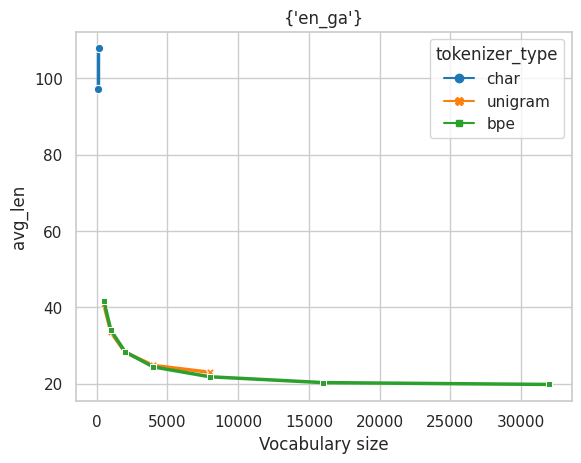

In [109]:
p.plot('avg_len')

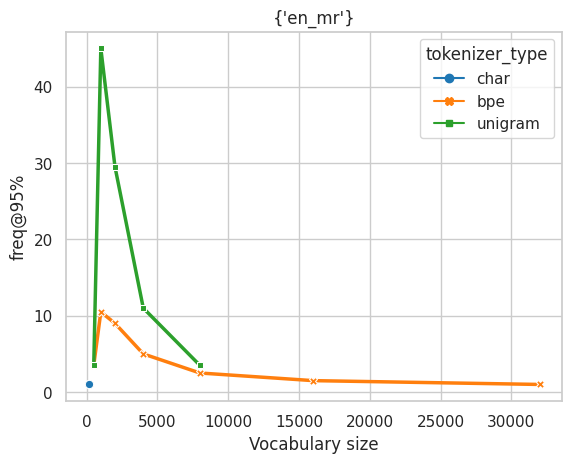

In [110]:
p2.plot('freq@95%')

In [ ]:
"""generate env var and run from server screen ctrl+a d, and to reconnect screen -r

or redirect all the outputs on a file and run the process with nohup and & (running in bg)"""

In [ ]:
class BleuTester:
    """
    trains nmt from tokenized with tokenizers,
    translates,
    computes bleu scores and plots results
    """
    
    def __init__(self, pair, tokenizers):
        self.pair = pair.split('-')
        self.src_lang = self.pair[0]
        self.tgt_lang = self.pair[1]
        
    def tokenize(self, ):
        """
        loads tokenizer, 
        tokenizes train.lang,
        returns tokenized, speed
        """
    
    def generate_env_var(self, ):
        """
        generate env_vars for current run
        """
        
        env_vars = 'export DATA_PATH= ../data

        export VOCAB_SOURCE=${DATA_PATH}/vocab.bpe.32000
        export VOCAB_TARGET=${DATA_PATH}/vocab.bpe.32000
        export TRAIN_SOURCES=${DATA_PATH}/toks_0.5k.en
        export TRAIN_TARGETS=${DATA_PATH}/toks_0.5k.mr
        export DEV_SOURCES=${DATA_PATH}/newstest2013.tok.bpe.32000.en
        export DEV_TARGETS=${DATA_PATH}/newstest2013.tok.bpe.32000.de

        export DEV_TARGETS_REF=${DATA_PATH}/newstest2013.tok.de
        export TRAIN_STEPS=1000000'
    
    def train_nmt(self,):
        """
        loads tokenized,
        trains model
        """
        
    def translate(self, ):
        """
        loads model,
        loads dev or test,
        translates
        returns translation
        """
    
    def compute_bleu(self, ):
        """
        loads translation,
        computes bleu,
        returns list of bleu scores
        """
    
    def plot(self, ):
        """
        plots results
        """
    def run(self):
        """
        runs the whole thing
        """class BleuTester:
    def __init__(self,):
        
    def train_nmt(self,)
    
    def compute_bleu(self,)
    
    def run(self):